# Timm Training For UWB Classification (Version: 1.3)

**Contact**: Parin 🐧

**Changelog**:
- *1.1*: Added Gradient Accumulation
- *1.2*: Added Cross Validation (**Credit: P'Film**)
- *1.3*: Added Weighted Ensemble


# Installing Requirements

In [ ]:
!pip install torch transformers datasets evaluate pillow==9.2.0
!pip install git+https://github.com/rwightman/pytorch-image-models.git

# Restart Kernel
import os
os.kill(os.getpid(), 9)

# Load Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [4]:
!cp -r /content/drive/MyDrive/SuperAI/Signal/signal ./

# Intialize Training

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

## Data Processing

In [5]:
train_files = glob.glob("signal/signal_train/**/*.png")
test_files = glob.glob("signal/signal_test/*.png")

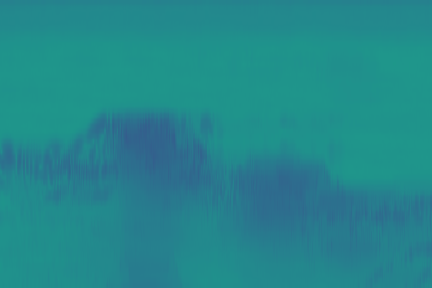

In [6]:
example = Image.open(train_files[0]).convert("RGB")
display(example)

In [7]:
transforms = {
    "train": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}


In [8]:
toImage = T.ToPILImage()

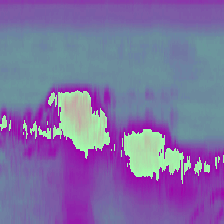

In [9]:
toImage(transforms["train"](example))

In [10]:
dataset = ImageDataset("signal/signal_train", transform=transforms["train"])

# Model Training

In [11]:
# List all available models
timm.list_models("")

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_2_rw_384',
 'coatnet_rmlp_3_rw_224',
 'coatnet_rmlp_nano_rw

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model_name = "hf_hub:timm/maxvit_base_tf_224.in1k"

In [14]:
num_epochs = 25
criterion = nn.CrossEntropyLoss()

# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 8
eval_batch_size = 16
num_accumulate = 4

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("f1")

In [15]:
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [16]:
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of 5")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=7).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)
    
    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
    }
    
    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []
    
        train_preds = []
        train_targets = []
    
        val_preds = []
        val_targets = []
    
        num_updates = epoch * len(train_dataloader)
    
        # Train Loop
        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
    
            loss.backward()
    
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
    
            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
    
        optimizer.sync_lookahead()
        scheduler.step(epoch + 1)
    
        # Eval Loop
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
    
                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        
        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]
    
        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)
    
        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))
    
        if metric_val > info["best_metric_val"]:
            print("New Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"checkpoint_fold{fold}.pt")
        
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")
    
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723], 'metric_val': [0.5132083987674051], 'train_loss': [1.4752603677602916], 'val_loss': [1.0586229628986783], 'best_metric_val': 0.5132083987674051}
Fold: 0 | Epoch: 0 | Metric: 0.5132083987674051 | Training Loss: 1.4752603677602916 | Validation Loss: 1.0586229628986783


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723, 0.7394612077790822], 'metric_val': [0.5132083987674051, 0.8316141574165082], 'train_loss': [1.4752603677602916, 0.6884244797321466], 'val_loss': [1.0586229628986783, 0.5903386225303014], 'best_metric_val': 0.8316141574165082}
Fold: 0 | Epoch: 1 | Metric: 0.8316141574165082 | Training Loss: 0.6884244797321466 | Validation Loss: 0.5903386225303014


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961], 'best_metric_val': 0.8316141574165082}
Fold: 0 | Epoch: 2 | Metric: 0.7394425987449244 | Training Loss: 0.4021496345790533 | Validation Loss: 0.7769713881942961


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916], 'best_metric_val': 0.8316141574165082}
Fold: 0 | Epoch: 3 | Metric: 0.794896775976105 | Training Loss: 0.2483611496595236 | Validation Loss: 0.5400324397616916


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127], 'best_metric_val': 0.8316141574165082}
Fold: 0 | Epoch: 4 | Metric: 0.7873491403856964 | Training Loss: 0.12605443556721393 | Validation Loss: 0.6750311512086127


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593], 'best_metric_val': 0.8356248614751172}
Fold: 0 | Epoch: 5 | Metric: 0.8356248614751172 | Training Loss: 0.1031230876293893 | Validation Loss: 0.503953619963593


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852], 'best_metric_val': 0.8356248614751172}
Fold: 0 | Epoch: 6 | Metric: 0.7902409818259889 | Training Loss: 0.12723668038558503 | Validation Loss: 0.7368072345852852


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094], 'best_metric_val': 0.8356248614751172}
Fold: 0 | Epoch: 7 | Metric: 0.8153239605461567 | Training Loss: 0.1509032476765032 | Validation Loss: 0.5820785752601094


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094, 0.7041671913531091], 'best_metric_val': 0.8356248614751172}
Fold: 0 | Epoch: 8 | Metric: 0.7511094547709194 | Training Loss: 0.07108249922211353 | Validation Loss: 0.7041671913531091


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094, 0.7041671913531091, 0.49474891513172126], 'best_metric_val': 0.8488031873324384}
Fold: 0 | Epoch: 9 | Metric: 0.8488031873324384 | Training Loss: 0.04880514

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094, 0.7041671913531091, 0.49474891513172126, 0.5627055311989453], 'best_metric_val': 0.8488031873324384}
Fold: 0 |

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094, 0.7041671913531091, 0.49474891513172126, 0.56270

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.503953619963593, 0.7368072345852852, 0.5820785752601094, 0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.5400324397616916, 0.6750311512086127, 0.5039536199

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297, 0.0029974323966038916], 'val_loss': [1.0586229628986783, 0.5903386225303014, 0.7769713881942961, 0.54

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297, 0.0029974323966038916, 0.0024754000003807818], 'val_loss': [1.05862296289867

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297, 0.0029974323966038916, 0.0024754000003807818, 0.001

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297, 0.0029974323966038916, 0.0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171, 0.0027491392388653297, 0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.009178891754709184, 0.005949286976829171,

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607, 0.8242465921692225], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.009749610962059636, 0.0091788917547091

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607, 0.8242465921692225, 0.843855049157276], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.07108249922211353, 0.048805144063841836, 0.00974961096205

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607, 0.8242465921692225, 0.843855049157276, 0.8498305820382802], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.0710824992221135

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607, 0.8242465921692225, 0.843855049157276, 0.8498305820382802, 0.8162391321005737], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.12723668038558503, 0.1509032476765032, 0.0710824

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.38626525737054723, 0.7394612077790822, 0.8599690058050593, 0.9131677609894664, 0.9607271429056373, 0.9655726466633237, 0.9563345701728826, 0.9489361706655027, 0.9732129487515188, 0.9898456874246592, 0.9961796093013778, 0.9982745858750862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5132083987674051, 0.8316141574165082, 0.7394425987449244, 0.794896775976105, 0.7873491403856964, 0.8356248614751172, 0.7902409818259889, 0.8153239605461567, 0.7511094547709194, 0.8488031873324384, 0.7772266331716199, 0.7742872332346016, 0.8383245025242827, 0.8188208616780045, 0.8187832181621001, 0.8188056338654972, 0.8461068957361965, 0.8437903402452466, 0.8264241898907182, 0.8333844209620607, 0.8242465921692225, 0.843855049157276, 0.8498305820382802, 0.8162391321005737, 0.8529021413069523], 'train_loss': [1.4752603677602916, 0.6884244797321466, 0.4021496345790533, 0.2483611496595236, 0.12605443556721393, 0.1031230876293893, 0.1272366

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.362515267208772], 'metric_val': [0.4913711102359635], 'train_loss': [1.523825180530548], 'val_loss': [1.2840870883729723], 'best_metric_val': 0.4913711102359635}
Fold: 1 | Epoch: 0 | Metric: 0.4913711102359635 | Training Loss: 1.523825180530548 | Validation Loss: 1.2840870883729723


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.362515267208772, 0.6536857286807074], 'metric_val': [0.4913711102359635, 0.7525196980690164], 'train_loss': [1.523825180530548, 0.8523362274353321], 'val_loss': [1.2840870883729723, 0.6530018018351661], 'best_metric_val': 0.7525196980690164}
Fold: 1 | Epoch: 1 | Metric: 0.7525196980690164 | Training Loss: 0.8523362274353321 | Validation Loss: 0.6530018018351661


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835], 'best_metric_val': 0.7525196980690164}
Fold: 1 | Epoch: 2 | Metric: 0.7498293199795409 | Training Loss: 0.4828985656683262 | Validation Loss: 0.6329861763450835


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592], 'best_metric_val': 0.7525196980690164}
Fold: 1 | Epoch: 3 | Metric: 0.5583038455852983 | Training Loss: 0.2845566428051545 | Validation Loss: 1.0863854694697592


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132], 'best_metric_val': 0.7525196980690164}
Fold: 1 | Epoch: 4 | Metric: 0.7488684806603716 | Training Loss: 0.26008060947060585 | Validation Loss: 0.619147372018132


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362], 'best_metric_val': 0.7766196727824937}
Fold: 1 | Epoch: 5 | Metric: 0.7766196727824937 | Training Loss: 0.13655121552829558 | Validation Loss: 0.5845672190189362


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927], 'best_metric_val': 0.838400667873892}
Fold: 1 | Epoch: 6 | Metric: 0.838400667873892 | Training Loss: 0.08109273151852764 | Validation Loss: 0.6025601633720927


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.4731420162651274], 'best_metric_val': 0.838400667873892}
Fold: 1 | Epoch: 7 | Metric: 0.8000907029478459 | Training Loss: 0.06305905694070343 | Validation Loss: 0.4731420162651274


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.4731420162651274, 0.7041176219677759], 'best_metric_val': 0.838400667873892}
Fold: 1 | Epoch: 8 | Metric: 0.7791789302561717 | Training Loss: 0.03579196518000502 | Validation Loss: 0.7041176219677759


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.4731420162651274, 0.7041176219677759, 1.0191929237399664], 'best_metric_val': 0.838400667873892}
Fold: 1 | Epoch: 9 | Metric: 0.6981828391734052 | Training Loss: 0.06992463608129093 | Validatio

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.4731420162651274, 0.7041176219677759, 1.0191929237399664, 0.49827434888316524], 'best_metric_val': 0.842329558913609

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.4731420162651274, 0.7041176219677759, 1.0191929237399664, 0.4982743488

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.619147372018132, 0.5845672190189362, 0.6025601633720927, 0.47314201

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836, 0.009521995515276034], 'val_loss': [1.2840870883729723, 0.6530018018351661, 0.6329861763450835, 1.0863854694697592, 0.61914

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836, 0.009521995515276034, 0.004626184479834942], 'val_loss': [1.2840870883729723, 0.6530018018351661, 

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836, 0.009521995515276034, 0.004626184479834942, 0.012984063712

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836, 0.009521995515276034, 0.004626184

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010181281842792836, 0.009521

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.018945212185812684, 0.010

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093, 0.07340838237522314, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858, 0.8265907901622187], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.03579196518000502, 0.06992463608129093

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858, 0.8265907901622187, 0.8405368441082727], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.06305905694070343, 0.0357919651800

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858, 0.8265907901622187, 0.8405368441082727, 0.8028109579146445], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109273151852764, 0.063059056

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858, 0.8265907901622187, 0.8405368441082727, 0.8028109579146445, 0.8167570118606985], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.13655121552829558, 0.08109

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.362515267208772, 0.6536857286807074, 0.8254830073656301, 0.9008615471843049, 0.8989306638927682, 0.9445939803920487, 0.9733168919643356, 0.9803684571541714, 0.987610367237303, 0.9748696580878239, 0.9804612723387273, 0.9982944249013964, 0.9968357713455752, 0.9984113962785005, 1.0, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4913711102359635, 0.7525196980690164, 0.7498293199795409, 0.5583038455852983, 0.7488684806603716, 0.7766196727824937, 0.838400667873892, 0.8000907029478459, 0.7791789302561717, 0.6981828391734052, 0.8423295589136098, 0.8362585656615492, 0.8258045334082201, 0.8125988324675567, 0.8043562182099049, 0.8353802943088658, 0.8302880203513844, 0.8299841225363874, 0.8299841225363874, 0.8353465869299858, 0.8265907901622187, 0.8405368441082727, 0.8028109579146445, 0.8167570118606985, 0.8357256721304996], 'train_loss': [1.523825180530548, 0.8523362274353321, 0.4828985656683262, 0.2845566428051545, 0.26008060947060585, 0.1

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3992594744343027], 'metric_val': [0.42471655328798186], 'train_loss': [1.3808922804318942], 'val_loss': [1.1057527661323547], 'best_metric_val': 0.42471655328798186}
Fold: 2 | Epoch: 0 | Metric: 0.42471655328798186 | Training Loss: 1.3808922804318942 | Validation Loss: 1.1057527661323547


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3992594744343027, 0.7150699999525132], 'metric_val': [0.42471655328798186, 0.8177831479060159], 'train_loss': [1.3808922804318942, 0.7247175507820569], 'val_loss': [1.1057527661323547, 0.437760579917166], 'best_metric_val': 0.8177831479060159}
Fold: 2 | Epoch: 1 | Metric: 0.8177831479060159 | Training Loss: 0.7247175507820569 | Validation Loss: 0.437760579917166


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974], 'best_metric_val': 0.8335623678646934}
Fold: 2 | Epoch: 2 | Metric: 0.8335623678646934 | Training Loss: 0.38500042494673 | Validation Loss: 0.49222399873865974


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635], 'best_metric_val': 0.862929816553099}
Fold: 2 | Epoch: 3 | Metric: 0.862929816553099 | Training Loss: 0.27665627607359333 | Validation Loss: 0.41141939390864635


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051], 'best_metric_val': 0.862929816553099}
Fold: 2 | Epoch: 4 | Metric: 0.7470854531436905 | Training Loss: 0.21402839789023767 | Validation Loss: 0.9271159875724051


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316], 'best_metric_val': 0.862929816553099}
Fold: 2 | Epoch: 5 | Metric: 0.8581844894462706 | Training Loss: 0.20990198597025414 | Validation Loss: 0.41843832718829316


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033], 'best_metric_val': 0.862929816553099}
Fold: 2 | Epoch: 6 | Metric: 0.8396750878558755 | Training Loss: 0.11770896330619088 | Validation Loss: 0.44251566256086033


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.46630836790427566], 'best_metric_val': 0.8802223507486665}
Fold: 2 | Epoch: 7 | Metric: 0.8802223507486665 | Training Loss: 0.028425759764818044 | Validation Loss: 0.46630836790427566


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.46630836790427566, 0.4656052531984945], 'best_metric_val': 0.8802223507486665}
Fold: 2 | Epoch: 8 | Metric: 0.866781899280057 | Training Loss: 0.011246840394316957 | Validation Loss: 0.4656052531984945


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.46630836790427566, 0.4656052531984945, 0.5836972167404989], 'best_metric_val': 0.8802223507486665}
Fold: 2 | Epoch: 9 | Metric: 0.8274341444595847 | Training Loss: 0.06208766447021984 | V

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.46630836790427566, 0.4656052531984945, 0.5836972167404989, 0.5092624322407775], 'best_metric_val': 0.8802223507486665}
Fold: 2

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.46630836790427566, 0.4656052531984945, 0.5836972167404989, 0.509

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271159875724051, 0.41843832718829316, 0.44251566256086033, 0.466

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236, 0.010234668261658114], 'val_loss': [1.1057527661323547, 0.437760579917166, 0.49222399873865974, 0.41141939390864635, 0.9271

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236, 0.010234668261658114, 0.009123178247290736], 'val_loss': [1.1057527661323547, 0.437

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236, 0.010234668261658114, 0.009123178247290736, 0.002915717442

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236, 0.010234668261658114, 0.009123178

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.02994145962696236, 0.010234

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.025543325329915836, 0.029

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984, 0.05506828926646939, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225, 0.839976935429867], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316957, 0.06208766447021984,

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225, 0.839976935429867, 0.8324320311532138], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088, 0.028425759764818044, 0.011246840394316

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983664935149792], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225, 0.839976935429867, 0.8324320311532138, 0.8541067929180451], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.20990198597025414, 0.11770896330619088,

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983664935149792, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225, 0.839976935429867, 0.8324320311532138, 0.8541067929180451, 0.845282288052414], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789023767, 0.209901985970254

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3992594744343027, 0.7150699999525132, 0.8865099182274896, 0.9061501528201401, 0.9267135390686221, 0.9233811109733472, 0.9736464986672185, 0.99686986863711, 0.9983923773397458, 0.9871443016033511, 0.9872562878663695, 0.9903977212888914, 0.9920981151631306, 0.9983935960435534, 0.9983664935149792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983664935149792, 1.0, 1.0], 'metric_val': [0.42471655328798186, 0.8177831479060159, 0.8335623678646934, 0.862929816553099, 0.7470854531436905, 0.8581844894462706, 0.8396750878558755, 0.8802223507486665, 0.866781899280057, 0.8274341444595847, 0.8460381107516185, 0.8404828044316364, 0.8202637024226229, 0.846391113545476, 0.8336797911585235, 0.8324320311532138, 0.8387728435225826, 0.8599838253332646, 0.839976935429867, 0.8495378691730225, 0.839976935429867, 0.8324320311532138, 0.8541067929180451, 0.845282288052414, 0.8264039039996927], 'train_loss': [1.3808922804318942, 0.7247175507820569, 0.38500042494673, 0.27665627607359333, 0.21402839789

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.36820197588565834], 'metric_val': [0.40846984680615517], 'train_loss': [1.4094273979847247], 'val_loss': [1.428955591387219], 'best_metric_val': 0.40846984680615517}
Fold: 3 | Epoch: 0 | Metric: 0.40846984680615517 | Training Loss: 1.4094273979847247 | Validation Loss: 1.428955591387219


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.36820197588565834, 0.6726494948154027], 'metric_val': [0.40846984680615517, 0.615279050591849], 'train_loss': [1.4094273979847247, 0.8183490349696233], 'val_loss': [1.428955591387219, 0.9309442208872901], 'best_metric_val': 0.615279050591849}
Fold: 3 | Epoch: 1 | Metric: 0.615279050591849 | Training Loss: 0.8183490349696233 | Validation Loss: 0.9309442208872901


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557], 'best_metric_val': 0.7270875085053389}
Fold: 3 | Epoch: 2 | Metric: 0.7270875085053389 | Training Loss: 0.4937145436039338 | Validation Loss: 0.7491480890247557


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127], 'best_metric_val': 0.7270875085053389}
Fold: 3 | Epoch: 3 | Metric: 0.7129997453526865 | Training Loss: 0.2712938964366913 | Validation Loss: 0.868822056800127


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256], 'best_metric_val': 0.7733801866454927}
Fold: 3 | Epoch: 4 | Metric: 0.7733801866454927 | Training Loss: 0.2310669045178936 | Validation Loss: 0.6739551602966256


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745], 'best_metric_val': 0.8170795372153165}
Fold: 3 | Epoch: 5 | Metric: 0.8170795372153165 | Training Loss: 0.14959393090640122 | Validation Loss: 0.5503882037268745


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437], 'best_metric_val': 0.8170795372153165}
Fold: 3 | Epoch: 6 | Metric: 0.7513740159175484 | Training Loss: 0.17839414046074337 | Validation Loss: 0.7384892404079437


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712], 'best_metric_val': 0.8170795372153165}
Fold: 3 | Epoch: 7 | Metric: 0.786907536907537 | Training Loss: 0.11228990079118656 | Validation Loss: 0.7127714670366712


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712, 1.2035611520210903], 'best_metric_val': 0.8170795372153165}
Fold: 3 | Epoch: 8 | Metric: 0.6724163870517604 | Training Loss: 0.08813472732615013 | Validation Loss: 1.2035611520210903


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712, 1.2035611520210903, 0.7168447002768517], 'best_metric_val': 0.8170795372153165}
Fold: 3 | Epoch: 9 | Metric: 0.7849711862767086 | Training Loss: 0.07549897256092383 | Valida

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712, 1.2035611520210903, 0.7168447002768517, 0.6547235854797893], 'best_metric_val': 0.8170795372153165}
Fold: 3 | E

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712, 1.2035611520210903, 0.7168447002768517, 0.6547235854797893, 0.69

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.7384892404079437, 0.7127714670366712, 1.203561152021090

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.6739551602966256, 0.5503882037268745, 0.73848924

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605, 0.0028331376648006532], 'val_loss': [1.428955591387219, 0.9309442208872901, 0.7491480890247557, 0.868822056800127, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605, 0.0028331376648006532, 0.0025066753043434943], 'val_loss': [1.428955591387219, 0.93094422088

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605, 0.0028331376648006532, 0.0025066753043434943, 0.0023391926965604607

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605, 0.0028331376648006532, 0.00250667530434349

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273602605, 0.002833137664800

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758180754689, 0.003419310273

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763, 0.7608934924724398], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401782584161713, 0.003948758

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763, 0.7608934924724398, 0.7726692418622019], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030564790183248428, 0.009401

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763, 0.7608934924724398, 0.7726692418622019, 0.7662336081889949], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0.07549897256092383, 0.030

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763, 0.7608934924724398, 0.7726692418622019, 0.7662336081889949, 0.7479018732773064], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.11228990079118656, 0.08813472732615013, 0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.36820197588565834, 0.6726494948154027, 0.8471526723883848, 0.9066739393399289, 0.9296596767333043, 0.9552992811086612, 0.9476987271686858, 0.9706706972414476, 0.9756092443332486, 0.9843759706149393, 0.9917368729711373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.40846984680615517, 0.615279050591849, 0.7270875085053389, 0.7129997453526865, 0.7733801866454927, 0.8170795372153165, 0.7513740159175484, 0.786907536907537, 0.6724163870517604, 0.7849711862767086, 0.7580449304457513, 0.7883020294071506, 0.8116070811488602, 0.7721023293038144, 0.7608004442537132, 0.7769376108237321, 0.7837080992493106, 0.7604043694474841, 0.7546004758942763, 0.7546004758942763, 0.7608934924724398, 0.7726692418622019, 0.7662336081889949, 0.7479018732773064, 0.7783287674043974], 'train_loss': [1.4094273979847247, 0.8183490349696233, 0.4937145436039338, 0.2712938964366913, 0.2310669045178936, 0.14959393090640122, 0.17839414046074337, 0.1122899007911865

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419], 'metric_val': [0.5586012771423107], 'train_loss': [1.4776748638886672], 'val_loss': [1.18919504682223], 'best_metric_val': 0.5586012771423107}
Fold: 4 | Epoch: 0 | Metric: 0.5586012771423107 | Training Loss: 1.4776748638886672 | Validation Loss: 1.18919504682223


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534], 'metric_val': [0.5586012771423107, 0.6302307492870105], 'train_loss': [1.4776748638886672, 0.9047350071943723], 'val_loss': [1.18919504682223, 0.9637507332695855], 'best_metric_val': 0.6302307492870105}
Fold: 4 | Epoch: 1 | Metric: 0.6302307492870105 | Training Loss: 0.9047350071943723 | Validation Loss: 0.9637507332695855


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294], 'best_metric_val': 0.7611588495047142}
Fold: 4 | Epoch: 2 | Metric: 0.7611588495047142 | Training Loss: 0.6009987384080887 | Validation Loss: 0.6451755861441294


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381], 'best_metric_val': 0.7611588495047142}
Fold: 4 | Epoch: 3 | Metric: 0.6953640570661849 | Training Loss: 0.3548717338878375 | Validation Loss: 0.8515778150823381


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164], 'best_metric_val': 0.7777105237338534}
Fold: 4 | Epoch: 4 | Metric: 0.7777105237338534 | Training Loss: 0.24670702287783988 | Validation Loss: 0.7076003121005164


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191], 'best_metric_val': 0.8109594531810335}
Fold: 4 | Epoch: 5 | Metric: 0.8109594531810335 | Training Loss: 0.1614547285752801 | Validation Loss: 0.6347637147539191


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626], 'best_metric_val': 0.8109594531810335}
Fold: 4 | Epoch: 6 | Metric: 0.7640047323277138 | Training Loss: 0.15811022591705506 | Validation Loss: 0.6898670204811626


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161983], 'best_metric_val': 0.8128592255017528}
Fold: 4 | Epoch: 7 | Metric: 0.8128592255017528 | Training Loss: 0.0755948887923016 | Validation Loss: 0.531577029161983


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161983, 0.6136644180450175], 'best_metric_val': 0.8128592255017528}
Fold: 4 | Epoch: 8 | Metric: 0.784233926667444 | Training Loss: 0.05073335341965923 | Validation Loss: 0.6136644180450175


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161983, 0.6136644180450175, 0.5353069942858484], 'best_metric_val': 0.8615862779478339}
Fold: 4 | Epoch: 9 | Metric: 0.8615862779478339 | Training Loss: 0.048842730878207

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161983, 0.6136644180450175, 0.5353069942858484, 0.7045987082852257], 'best_metric_val': 0.8615862779478339}
Fold: 4 | Epoch:

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161983, 0.6136644180450175, 0.5353069942858484, 0.70459870828522

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.7076003121005164, 0.6347637147539191, 0.6898670204811626, 0.531577029161

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0.01288205715827644], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.6451755861441294, 0.8515778150823381, 0.70760031210

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0.01288205715827644, 0.0050091620695848875], 'val_loss': [1.18919504682223, 0.9637507332695855, 0.645

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0.01288205715827644, 0.0050091620695848875, 0.0032312840706883715], 'val_los

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0.01288205715827644, 0.0050091620695848875, 0.00323

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0.01288205715827644, 0.005

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.06604992591131192, 0.04243124480574177, 0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.020900162298662157, 0.0660499259113119

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957, 0.8415783529971173], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.04884273087820755, 0.0209001622986

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957, 0.8415783529971173, 0.8427115934816429], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073335341965923, 0.048842730

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957, 0.8415783529971173, 0.8427115934816429, 0.8544295618822485], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0755948887923016, 0.05073

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957, 0.8415783529971173, 0.8427115934816429, 0.8544295618822485, 0.841660175936083], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801, 0.15811022591705506, 0.0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.3584797221553419, 0.6328910788476534, 0.7777564403286144, 0.8874918328051215, 0.9176265170380894, 0.9514232973196269, 0.9558171678161579, 0.9810439562552112, 0.989058579045624, 0.984118974119453, 0.9900474436721771, 0.9654671450449218, 0.9780788745824186, 0.9929703995638061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.5586012771423107, 0.6302307492870105, 0.7611588495047142, 0.6953640570661849, 0.7777105237338534, 0.8109594531810335, 0.7640047323277138, 0.8128592255017528, 0.784233926667444, 0.8615862779478339, 0.7492979218071018, 0.780239307730597, 0.8555476178953353, 0.8336564712871333, 0.8469506602967947, 0.8221676720092732, 0.8295225977852516, 0.8549008259651326, 0.8417693569540354, 0.8489332787730957, 0.8415783529971173, 0.8427115934816429, 0.8544295618822485, 0.841660175936083, 0.8415783529971173], 'train_loss': [1.4776748638886672, 0.9047350071943723, 0.6009987384080887, 0.3548717338878375, 0.24670702287783988, 0.1614547285752801,

In [17]:
!cp checkpoint*.pt drive/MyDrive/

# Error Analysis

  0%|          | 0/9 [00:00<?, ?it/s]

Fold: 0


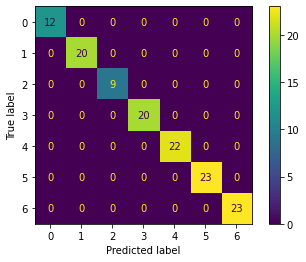

  0%|          | 0/9 [00:00<?, ?it/s]

Fold: 1


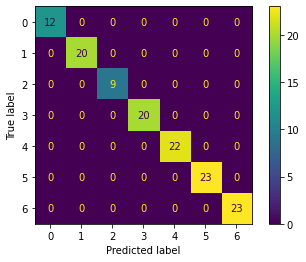

  0%|          | 0/9 [00:00<?, ?it/s]

Fold: 2


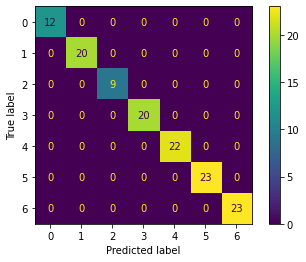

  0%|          | 0/9 [00:00<?, ?it/s]

Fold: 3


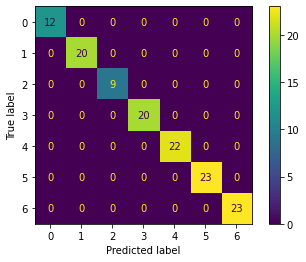

  0%|          | 0/9 [00:00<?, ?it/s]

Fold: 4


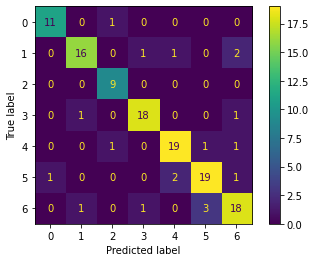

In [18]:
for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")
    predictions = []
    references = []
    
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))
    
            # Log Values
            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()
    
    print(f"Fold: {fold}")
    
    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    

# Inference

## Voting Classifier


In [19]:
answers_final = dict()

for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    model.eval() 
    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]
   
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            if fold == 0:
                answers_final[key] = [loaded_model(transformed).argmax(-1).item()]
            else:
                answers_final[key].append(loaded_model(transformed).argmax(-1).item())

for key in answers_final:
    # Take most occuring number 
    answers_final[key] = stats.mode(answers_final)[0][0]
    

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

<ipython-input-19-9c8242637614>:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  answers_final[key] = stats.mode(answers_final)[0][0]
<ipython-input-19-9c8242637614>:21: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  answers_final[key] = stats.mode(answers_final)[0][0]


TypeError: ignored

In [ ]:
with open(f"solution_maxvit_kfold{k_splits}_voting.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

### Weighted Ensemble

In [ ]:
answers_final = dict()

for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    model.eval() 

    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]
   
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            if fold == 0:
                answers_final[key] = loaded_model(transformed).cpu().numpy() * all_eval_scores[fold]
            else:
                answers_final[key] = answers_final[key] + (loaded_model(transformed).cpu().numpy() * all_eval_scores[fold])

for key in answers_final:
    # Take most occuring number 
    answers_final[key] = np.argmax(answers_final[key], -1).item()

In [ ]:
with open(f"solution_maxvit_kfold{k_splits}_weighted.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

### Model Soup Weight Averaging